#### Yu Han, July 2023.
We used logistic regression to classify four cell types for control patients only.  Feature importance score is printed. 

mann-whitney-u-test was adopted to run feature by feature analysis between the four cell types to find significant features.

Combining morph features and branching features.

In [117]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import statistics
import random
import scipy.stats as ss

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit

import warnings
warnings.filterwarnings("ignore")
from pycytominer import aggregate
import statsmodels.stats.multitest
from parse_cp_features import parse_cp_features

### read profile

In [118]:
# read neuron profile to df
df_neuron = pd.read_csv('profile/neuron_morph_branch_merge.csv')
#groupby Metadata_plate and Metadata_LINE_ID and get mean value of each feature
df_neuron = df_neuron.groupby(['Metadata_LINE_ID_x','Metadata_Well', 'Metadata_GENOTYPE_x']).mean().reset_index()
#change Metadata_LINE_ID_x to Metadata_LINE_ID and Metadata_GENOTYPE_x to Metadata_GENOTYPE
df_neuron = df_neuron.rename(columns={'Metadata_LINE_ID_x':'Metadata_LINE_ID', 'Metadata_GENOTYPE_x':'Metadata_GENOTYPE'})
#add column Cell_Type and fill with neuron
df_neuron['Metadata_Cell_Type'] = 'neuron'
df_neuron.head(2)

,Metadata_LINE_ID,Metadata_Well,Metadata_GENOTYPE,Metadata_DENSITY_x,Metadata_Site_Count_x,Metadata_Object_Count_x,Cells_AreaShape_Compactness,Cells_AreaShape_MedianRadius,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,...,Nuclei_Texture_SumVariance_Brightfield_20_00,Metadata_DENSITY_y,Metadata_LINE_ID_y,Metadata_Site_Count_y,Metadata_Object_Count_y,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel,Metadata_Cell_Type
0,1,A01,DELETION,3500.0,3.0,238.0,0.649155,-0.756705,0.402415,-0.242840,...,1.007540,3500.0,1.0,3.0,238.0,-0.766375,-0.666510,-0.131295,-0.886905,neuron
1,1,A02,DELETION,3500.0,3.0,340.0,-0.692455,-0.182364,0.411080,0.634642,...,0.197915,3500.0,1.0,3.0,340.0,-0.920980,-0.749215,-0.420865,-0.990425,neuron


In [119]:
# read stem profile to df
df_stem = pd.read_csv('profile/stem_morph.csv')
#change Metadata_line_ID to Metadata_LINE_ID and Metadata_line_condition to Metadata_GENOTYPE
df_stem = df_stem.rename(columns={'Metadata_line_ID':'Metadata_LINE_ID', 'Metadata_line_condition':'Metadata_GENOTYPE'})
df_stem['Metadata_Cell_Type'] = 'stem'
df_stem.head(2)

,Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_LINE_ID,Metadata_GENOTYPE,Metadata_line_source,Cells_AreaShape_Center_X,...,Nuclei_Texture_InfoMeas2_Brightfield_20_00,Nuclei_Texture_InfoMeas2_ER_10_03,Nuclei_Texture_InfoMeas2_RNA_10_03,Nuclei_Texture_InfoMeas2_RNA_20_01,Nuclei_Texture_InverseDifferenceMoment_ER_20_02,Nuclei_Texture_SumAverage_Brightfield_20_03,Nuclei_Texture_SumEntropy_Brightfield_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_10_00,Metadata_Cell_Type
0,BR_NCP_STEM_1,A01,BR_NCP_STEM_1,BR_NCP_STEM_1,A01,10000,1,control,human,0.50933,...,1.56270,1.1817,0.17543,0.000126,-0.89288,0.630330,0.63990,2.8473,0.82266,stem
1,BR_NCP_STEM_1,A02,BR_NCP_STEM_1,BR_NCP_STEM_1,A02,10000,1,control,human,-0.31877,...,0.65012,1.2649,1.45140,0.280320,-1.23480,-0.062683,-0.26259,2.7774,0.43155,stem


In [120]:
# read progenitor profile to df
df_progen = pd.read_csv('profile/progen_morph_branch_merge.csv')
#change Metadata_line_ID_x to Metadata_LINE_ID and Metadata_line_condition_x to Metadata_GENOTYPE
df_progen = df_progen.rename(columns={'Metadata_line_ID_x':'Metadata_LINE_ID', 'Metadata_line_condition_x':'Metadata_GENOTYPE'})
df_progen['Metadata_Cell_Type'] = 'progen'
df_progen.head(2)

,Metadata_Plate,Metadata_Well,Metadata_Site_Count_x,Metadata_Object_Count_x,Metadata_Assay_Plate_Barcode_x,Metadata_Plate_Map_Name_x,Metadata_well_position_x,Metadata_plating_density_x,Metadata_LINE_ID,Metadata_GENOTYPE,...,Metadata_well_position_y,Metadata_plating_density_y,Metadata_line_ID_y,Metadata_line_condition_y,Metadata_line_source_y,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel,Metadata_Cell_Type
0,BR00127194,A01,9,2486,BR00127194,BR00127194,A01,10000,1,control,...,A01,10000,1,control,human,10.899035,15.247385,4.276348,438.545231,progen
1,BR00127194,A02,9,3014,BR00127194,BR00127194,A02,10000,1,control,...,A02,10000,1,control,human,8.358660,12.026543,3.906105,368.728017,progen


In [121]:
# read astrocyte profile to df
df_astro = pd.read_csv('profile/astro_morph_branch_merge.csv')
#groupby Metadata_plate and Metadata_LINE_ID and get mean value of each feature
df_astro = df_astro.groupby(['Metadata_METADATA_SAMPLE_ID_x','Metadata_Well', 'Metadata_METADATA_CONDITION_x']).mean().reset_index()
#change Metadata_METADATA_SAMPLE_ID_x to Metadata_LINE_ID and Metadata_METADATA_CONDITION_x to Metadata_GENOTYPE
df_astro = df_astro.rename(columns={'Metadata_METADATA_SAMPLE_ID_x':'Metadata_LINE_ID', 'Metadata_METADATA_CONDITION_x':'Metadata_GENOTYPE'})
df_astro['Metadata_Cell_Type'] = 'astro'
df_astro.head(2)

,Metadata_LINE_ID,Metadata_Well,Metadata_GENOTYPE,Metadata_METADATA_DENSITY_x,Metadata_Site_Count_x,Metadata_Count_Cells_x,Metadata_Count_Cytoplasm_x,Metadata_Count_Nuclei_x,Metadata_Object_Count_x,Image_Granularity_10_Brightfield,...,Metadata_Site_Count_y,Metadata_Count_Cells_y,Metadata_Count_Cytoplasm_y,Metadata_Count_Nuclei_y,Metadata_Object_Count_y,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel,Metadata_Cell_Type
0,1,A01,CONTROL,5000.0,6.5,35.0,35.0,35.0,35.0,-1.131380,...,6.5,35.0,35.0,35.0,35.0,30.0975,29.5485,2.82255,2538.45,astro
1,1,C05,CONTROL,5000.0,7.0,41.5,41.5,41.5,41.5,-1.036655,...,7.0,41.5,41.5,41.5,41.5,67.9125,67.3560,3.27440,4316.00,astro


In [122]:
#concate neuron, stem, progenitor, astrocyte profile to df and keep only common columns
df = pd.concat([df_neuron, df_stem, df_progen, df_astro], axis=0, join='inner')
#change all strings to lower case
df['Metadata_GENOTYPE'] = df['Metadata_GENOTYPE'].str.lower()
df.head(2)

,Metadata_LINE_ID,Metadata_Well,Metadata_GENOTYPE,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,...,Nuclei_Texture_Correlation_Brightfield_20_02,Nuclei_Texture_Correlation_DNA_10_01,Nuclei_Texture_Correlation_DNA_10_02,Nuclei_Texture_Correlation_DNA_10_03,Nuclei_Texture_Correlation_ER_20_00,Nuclei_Texture_Correlation_ER_20_01,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_20_00,Nuclei_Texture_Correlation_Mito_20_03,Metadata_Cell_Type
0,1,A01,deletion,-0.242840,0.10070,-0.053765,0.551125,0.269150,0.421625,0.48595,...,0.786645,-1.083280,-0.764545,-0.91867,0.411774,0.047466,0.529805,1.251950,2.022225,neuron
1,1,A02,deletion,0.634642,-0.17572,0.539395,-0.227565,-0.433745,0.067733,-0.09567,...,1.144445,-0.500545,-0.324515,0.07865,-0.155440,-0.397030,-0.084225,1.343547,1.186329,neuron


In [123]:
#select all rows where Metadata_GENOTYPE = control from df
df_control = df[df['Metadata_GENOTYPE'] == 'control']
df_control.head(2)

,Metadata_LINE_ID,Metadata_Well,Metadata_GENOTYPE,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,...,Nuclei_Texture_Correlation_Brightfield_20_02,Nuclei_Texture_Correlation_DNA_10_01,Nuclei_Texture_Correlation_DNA_10_02,Nuclei_Texture_Correlation_DNA_10_03,Nuclei_Texture_Correlation_ER_20_00,Nuclei_Texture_Correlation_ER_20_01,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_20_00,Nuclei_Texture_Correlation_Mito_20_03,Metadata_Cell_Type
16,3,E21,control,-0.066390,-0.367965,-0.795985,-0.149525,-0.13874,1.042215,-0.221005,...,-0.661355,-0.496675,0.260225,0.220590,-0.244087,-0.76827,-0.353085,-0.349225,-0.218245,neuron
17,3,E22,control,-0.173415,0.488225,0.810530,0.199880,1.79825,-1.024650,-1.002515,...,-0.151045,0.267725,-0.000162,-0.140435,0.241944,0.51815,-1.109230,-0.068985,-0.336770,neuron


### logistic regression

In [124]:
#binary code cell types
df_control.Metadata_Cell_Type[df_control.Metadata_Cell_Type == 'neuron'] = 0
df_control.Metadata_Cell_Type[df_control.Metadata_Cell_Type == 'stem'] = 1
df_control.Metadata_Cell_Type[df_control.Metadata_Cell_Type == 'astro'] = 2
df_control.Metadata_Cell_Type[df_control.Metadata_Cell_Type == 'progen'] = 3

In [125]:
#select all feature columns
df_control_feat=df_control.loc[:,~df_control.columns.str.startswith('Metadata')]

In [126]:
### logistic regression 
#define X and y
X=df_control_feat.values
y=df_control['Metadata_Cell_Type'].tolist()
y0=np.array(y)

#split training and testing 
#using GroupShuffleSplit to ensure the same patient won't appear in train and test set at the same time
gss = GroupShuffleSplit(n_splits=4, train_size=.8, random_state=42)
gss.get_n_splits()
for train_idx, test_idx in gss.split(X, y0, df_control['Metadata_LINE_ID']):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y0[train_idx], y0[test_idx]

#fit the model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

#print acc score
score = logisticRegr.score(X_test, y_test)
score

0.668918918918919

### mann-whitney-u-test

In [127]:
#mean profile based on patient ID and genotype
df_control_mean= aggregate(
                    population_df=df_control, 
                    strata=['Metadata_LINE_ID', 'Metadata_Cell_Type'], 
                    features='infer', 
                    operation='mean' 
                    )
df_control_mean.head(2)

,Metadata_LINE_ID,Metadata_Cell_Type,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_3,...,Nuclei_Texture_Correlation_Brightfield_20_00,Nuclei_Texture_Correlation_Brightfield_20_02,Nuclei_Texture_Correlation_DNA_10_01,Nuclei_Texture_Correlation_DNA_10_02,Nuclei_Texture_Correlation_DNA_10_03,Nuclei_Texture_Correlation_ER_20_00,Nuclei_Texture_Correlation_ER_20_01,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_20_00,Nuclei_Texture_Correlation_Mito_20_03
0,1,1,0.224115,-0.771190,1.167344,0.008333,0.55524,0.330501,0.36614,-0.421600,...,-0.578724,0.034988,-0.087626,0.343036,-0.068087,0.051904,-0.154030,-0.017447,-0.339204,-0.609122
1,1,2,-5.515925,-0.851762,-0.631328,0.844518,1.11838,-0.626800,1.36924,-0.771523,...,2.491675,2.846603,1.868478,0.689275,0.676867,0.909415,1.245753,2.712600,1.826602,2.234750


In [128]:
#create feature list
feature_list=list(df_control_feat.columns)

In [129]:
#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

#### Neuron vs. Stem

In [130]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_control_mean.query('Metadata_Cell_Type == 0')[feat],          
           df_control_mean.query('Metadata_Cell_Type == 1')[feat])
    list_p.append(p)
    list_u.append(u)

In [131]:
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

In [132]:
#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]
df_p_values_feature

,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_4_0,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_0,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_3,Cells_AreaShape_Zernike_8_0,Cells_AreaShape_Zernike_8_2,...,Nuclei_Texture_Correlation_Brightfield_20_00,Nuclei_Texture_Correlation_Brightfield_20_02,Nuclei_Texture_Correlation_DNA_10_01,Nuclei_Texture_Correlation_DNA_10_02,Nuclei_Texture_Correlation_DNA_10_03,Nuclei_Texture_Correlation_ER_20_00,Nuclei_Texture_Correlation_ER_20_01,Nuclei_Texture_Correlation_ER_20_02,Nuclei_Texture_Correlation_Mito_20_00,Nuclei_Texture_Correlation_Mito_20_03
0,0.36953,0.00359235,0.0295569,0.00549064,0.0257776,0.0552093,0.00359235,0.0320688,0.00549064,0.00359235,...,0.194179,0.491022,0.0135403,0.418099,0.0132436,0.29807,0.0195209,0.35556,0.0032851,0.000674444


In [133]:
#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
sig_features=df_p_values_feature.columns
len(sig_features)

42

In [134]:
#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
channel_list

['XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'DNA_ER',
 'DNA_Mito',
 'AGP',
 'DNA',
 'RNA',
 'XNONE',
 'XNONE',
 'XNONE',
 'Brightfield_DNA',
 'DNA_Mito',
 'AGP',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'AGP_ER',
 'AGP',
 'Brightfield',
 'ER',
 'DNA',
 'DNA',
 'AGP',
 'DNA',
 'DNA',
 'ER',
 'Mito',
 'Mito']

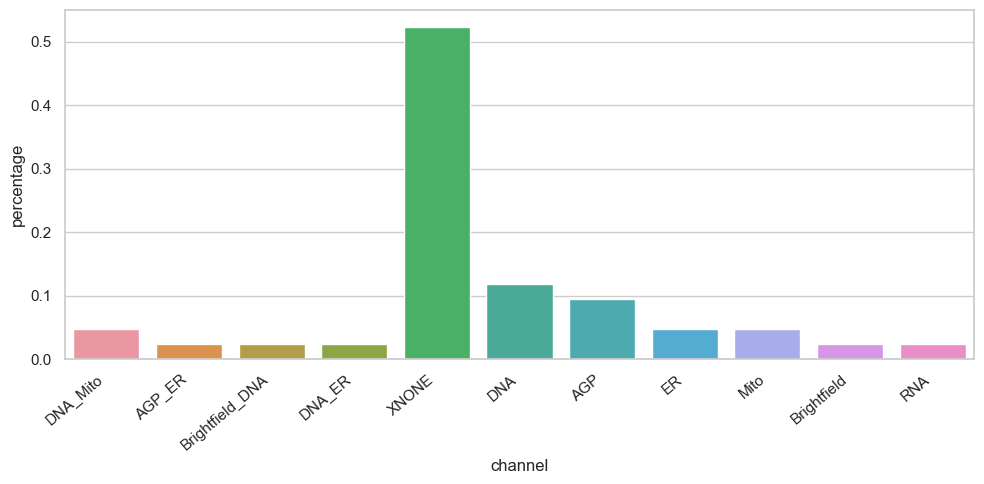

In [135]:
#plot each category of channel based on percentage
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#convert channel_list to a dataframe
df_channel=pd.DataFrame(channel_list,columns=['channel'])

#count the number of each category
df_channel_count=df_channel.groupby('channel').size().reset_index(name='counts')

#calculate the percentage of each category
df_channel_count['percentage']=df_channel_count['counts']/df_channel_count['counts'].sum()

#sort channel column based on whether it has a specific string "_"
df_channel_count['sort']=df_channel_count['channel'].str.contains('_')
#sort df_channel_count based on the sort column
df_channel_count=df_channel_count.sort_values(by=['sort','percentage'],ascending=False)
#plot the percentage of each category
plt.figure(figsize=(10,5))
ax = sns.barplot(x="channel", y="percentage", data=df_channel_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


#### Neuron vs. Astrocyte

In [136]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_control_mean.query('Metadata_Cell_Type == 0')[feat],          
           df_control_mean.query('Metadata_Cell_Type == 2')[feat])
    list_p.append(p)
    list_u.append(u)
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]

#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
sig_features=df_p_values_feature.columns

#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
channel_list

['XNONE',
 'DNA_ER',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'XNONE',
 'Brightfield',
 'ER',
 'Mito']

#### Neuron vs. Progenitor

In [137]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_control_mean.query('Metadata_Cell_Type == 0')[feat],          
           df_control_mean.query('Metadata_Cell_Type == 3')[feat])
    list_p.append(p)
    list_u.append(u)
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]

#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
sig_features=df_p_values_feature.columns

#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
channel_list

[]

#### Stem vs. Astrocyte

In [138]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_control_mean.query('Metadata_Cell_Type == 1')[feat],          
           df_control_mean.query('Metadata_Cell_Type == 2')[feat])
    list_p.append(p)
    list_u.append(u)
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]

#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
sig_features=df_p_values_feature.columns

#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
channel_list

[]

#### Stem vs. Progenitor

In [139]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_control_mean.query('Metadata_Cell_Type == 1')[feat],          
           df_control_mean.query('Metadata_Cell_Type == 3')[feat])
    list_p.append(p)
    list_u.append(u)
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]

#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
sig_features=df_p_values_feature.columns

#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
channel_list

[]

#### Astrocyte vs. Progenitor 

In [140]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_control_mean.query('Metadata_Cell_Type == 2')[feat],          
           df_control_mean.query('Metadata_Cell_Type == 3')[feat])
    list_p.append(p)
    list_u.append(u)
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]

#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
sig_features=df_p_values_feature.columns

#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
channel_list

[]